<a href="https://colab.research.google.com/github/CBJtech/CBJtech/blob/main/Formatted_Pytorch_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Steps:
     
*    Imports and Data Pipeline   (cleaning, and preprocessing)
*   Model Architecture    (Implemented CNN from scratch)
*   GPU Acceleration and Training (Utilized CUDA for faster training)
*   Visualization    (Monitoring of training progress in real time)
*   Model Evaluation (Proper train/validation split)
*   MODEL EVALUATION ON INDIVIDUAL SAMPLES (SINGLE IMAGE TESTING & VISUALIZATION)












      
      
      
      

In [1]:
# IMPORTS

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
import time


# ========================================
# DATASET AND TEST
# ========================================

# Download and extract data
!wget -q "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip" -O cats_dogs.zip
!unzip -q cats_dogs.zip -d data/

def get_jpg(directory_path):
    jpg_files = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            jpg_files.append(filename)
    return jpg_files

class DogsVSCatsDataset(Dataset):
    def __init__(self, transforms):
        self.path_cat = "/content/data/PetImages/Cat"
        self.path_dog = "/content/data/PetImages/Dog"
        self.cat_jpg = get_jpg("/content/data/PetImages/Cat")
        self.dog_jpg = get_jpg("/content/data/PetImages/Dog")
        self.images = self.cat_jpg + self.dog_jpg
        self.labels = [0]*len(self.cat_jpg) + [1]*len(self.dog_jpg)
        self.transform = transforms

        # Filter out images that cannot be read by cv2.imread
        valid_images = []
        valid_labels = []
        for i in range(len(self.images)):
            if i < len(self.cat_jpg):
                img_path = os.path.join(self.path_cat, self.images[i])
            else:
                img_path = os.path.join(self.path_dog, self.images[i])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                valid_images.append(self.images[i])
                valid_labels.append(self.labels[i])

        self.images = valid_images
        self.labels = valid_labels

    def __getitem__(self, index):
        if self.labels[index] == 0:  # Cat
            img_path = os.path.join(self.path_cat, self.images[index])
        else:  # Dog
            img_path = os.path.join(self.path_dog, self.images[index])

        label = self.labels[index]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.images)

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# dataset and dataloaders
dataset = DogsVSCatsDataset(transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)

# Test dataset
img, label = dataset[0]
print(f"train Dataset size: {len(train_dataset)}")
print(f"val Dataset size: {len(val_dataset)}")

# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


train Dataset size: 19997
val Dataset size: 5000
Running on the GPU


In [12]:
# ========================================
# MODEL
# ========================================
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)  # input 1, output 32 convolutional features, kernel size 5
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.fc1 = nn.Linear(128*12*12, 512) # 2*2 for spatial dimension
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        return x

    def forward(self, x):
        x = self.convs(x)
        # print(x.shape)
        x = x.view(-1, 128*12*12)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Remove softmax for CrossEntropyLoss
        return x


# ========================================
# TRAINING TESTING/VALIDATING
# ========================================

def fwd_pass(net, X, y, optimizer, loss_function, train=False):
    if train:
        net.zero_grad()

    outputs = net(X)
    # print(outputs.shape, y.shape)
    loss = loss_function(outputs, y)

    # accuracy
    predicted = torch.argmax(outputs, dim=1)
    correct = (predicted == y).sum().item()
    acc = correct / len(y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

def validate(net, val_dataloader, loss_function, device):
    net.eval()
    total_loss = 0
    total_acc = 0
    total_samples = 0

    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)

            predicted = torch.argmax(outputs, dim=1)
            correct = (predicted == batch_y).sum().item()

            total_loss += loss.item()
            total_acc += correct
            total_samples += len(batch_y)

    return total_loss / len(val_dataloader), total_acc / total_samples

def train_model(net, train_dataloader, val_dataloader, device, epochs=4, lr=0.001, model_name=None):
    if model_name is None:
        model_name = f"model-{int(time.time())}" #recording training and validation metrics over time

    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Create log file
    with open("model.log", "a") as f:
        f.write("model_name,timestamp,sample_type,accuracy,loss\n")

    net.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0

        for batch_X, batch_y in tqdm(train_dataloader):
            # print(batch_X.shape)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            acc, loss = fwd_pass(net, batch_X, batch_y, optimizer, loss_function, train=True)

            epoch_loss += loss.item()
            epoch_acc += acc
            num_batches += 1

            # Log training metrics
            with open("model.log", "a") as f:
                f.write(f"{model_name},{round(time.time(),3)},train,{round(acc,4)},{round(loss.item(),4)}\n")

        # Validation
        val_loss, val_acc = validate(net, val_dataloader, loss_function, device)

        print(f"Train Loss: {epoch_loss/num_batches:.4f}, Train Acc: {epoch_acc/num_batches:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 50)

        # Log validation metrics
        with open("model.log", "a") as f:
            f.write(f"{model_name},{round(time.time(),3)},val,{round(val_acc,4)},{round(val_loss,4)}\n")

    return model_name

"""def test_model(net, test_dataloader, device):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_dataloader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = net(batch_X)
            predicted = torch.argmax(outputs, dim=1)

            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.3f}")
    return accuracy

"""

# Initialize and train model
net = Net().to(device)
model_name = train_model(net, train_dataloader, val_dataloader, device, epochs=4)

Epoch 1/4


100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


Train Loss: 0.6471, Train Acc: 0.6206
Val Loss: 0.5733, Val Acc: 0.6946
--------------------------------------------------
Epoch 2/4


100%|██████████| 200/200 [00:52<00:00,  3.81it/s]


Train Loss: 0.5309, Train Acc: 0.7320
Val Loss: 0.4865, Val Acc: 0.7628
--------------------------------------------------
Epoch 3/4


100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


Train Loss: 0.4420, Train Acc: 0.7941
Val Loss: 0.4478, Val Acc: 0.7910
--------------------------------------------------
Epoch 4/4


100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


Train Loss: 0.3753, Train Acc: 0.8279
Val Loss: 0.4706, Val Acc: 0.7884
--------------------------------------------------


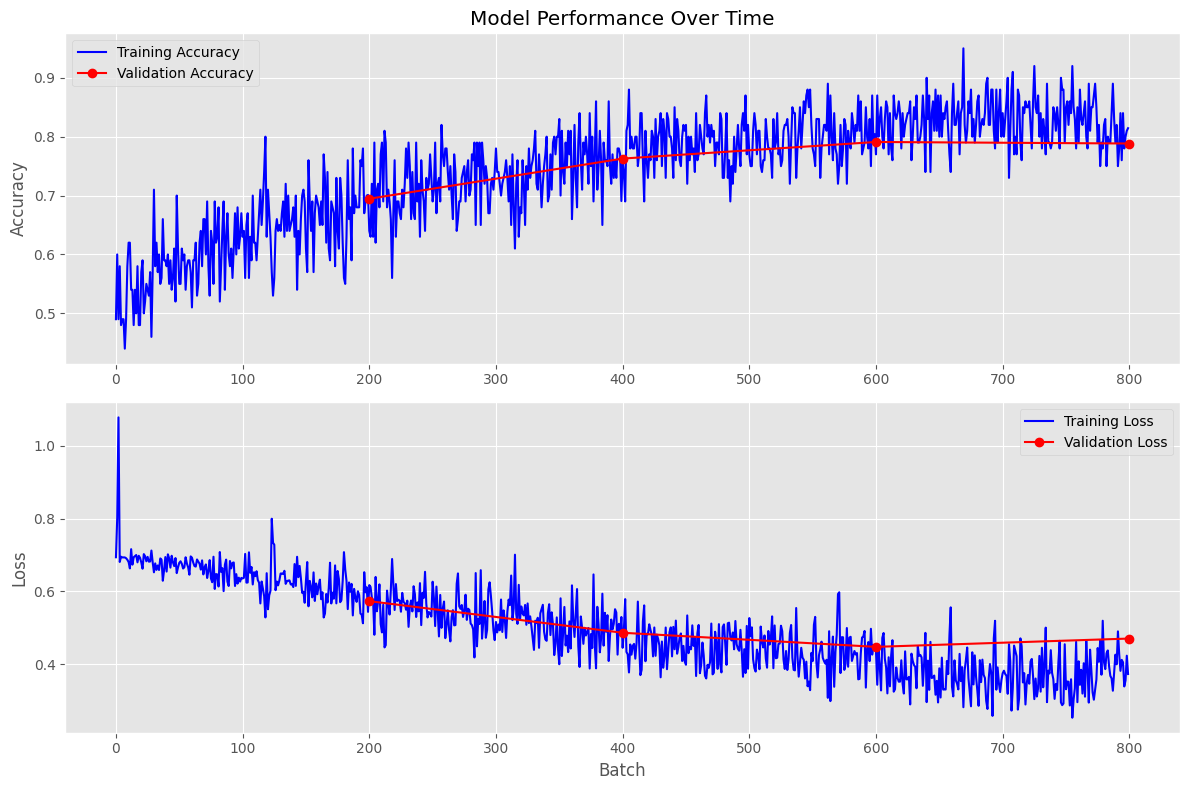

In [13]:

# ========================================
# PLOT LOSSES
# ========================================
style.use("ggplot")

def create_acc_loss_graph(model_name):
    try:
        contents = open("model.log", "r").read().split("\n")

        train_times = []
        train_accuracies = []
        train_losses = []
        val_times = []
        val_accuracies = []
        val_losses = []

        for c in contents[1:]:
            if c and model_name in c:
                try:
                    name, timestamp, sample_type, acc, loss = c.split(",")

                    if sample_type == "train":
                        train_times.append(float(timestamp))
                        train_accuracies.append(float(acc))
                        train_losses.append(float(loss))
                    elif sample_type == "val":
                        val_times.append(float(timestamp))
                        val_accuracies.append(float(acc))
                        val_losses.append(float(loss))
                except ValueError:
                    continue

        if not train_accuracies:
            print("No training data found for plotting")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Accuracies plot
        ax1.plot(train_accuracies, label="Training Accuracy", color='blue')
        if val_accuracies:
            value=len(train_accuracies)//len(val_accuracies)
            ax1.plot(range(value, len(train_accuracies)+1,value),
                    val_accuracies, label="Validation Accuracy", color='red', marker='o')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Performance Over Time')
        ax1.legend()
        ax1.grid(True)

        # Losses Plot
        ax2.plot(train_losses, label="Training Loss", color='blue')
        value_loss=len(train_losses)//len(val_losses)
        if val_losses:
            ax2.plot(range(value_loss, len(train_losses)+1, value_loss),
                    val_losses, label="Validation Loss", color='red', marker='o')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Batch')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("model.log file not found")

# Plots
create_acc_loss_graph(model_name)


TESTING THE TRAINED MODEL
Testing 3 random images from dataset...
torch.Size([1, 128, 12, 12])

Sample 1:
True Label: Cat
Prediction: Cat (98.8% confidence)
Correct: ✅


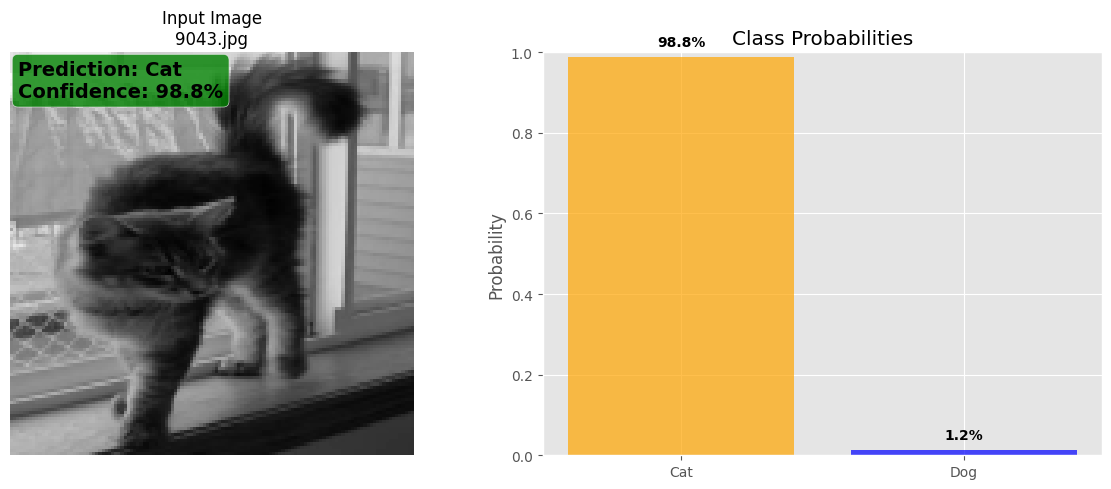

torch.Size([1, 128, 12, 12])

Sample 2:
True Label: Dog
Prediction: Dog (100.0% confidence)
Correct: ✅


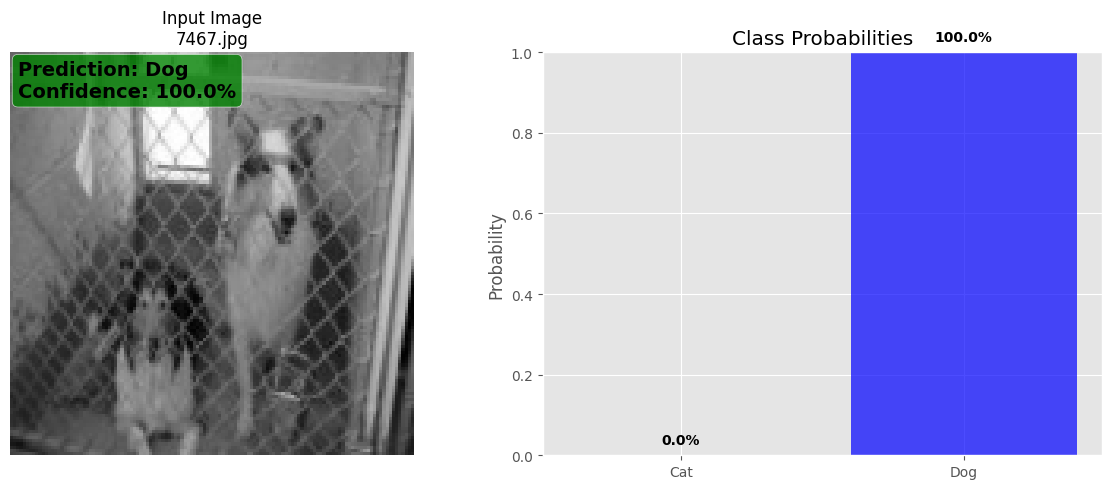

torch.Size([1, 128, 12, 12])

Sample 3:
True Label: Dog
Prediction: Dog (100.0% confidence)
Correct: ✅


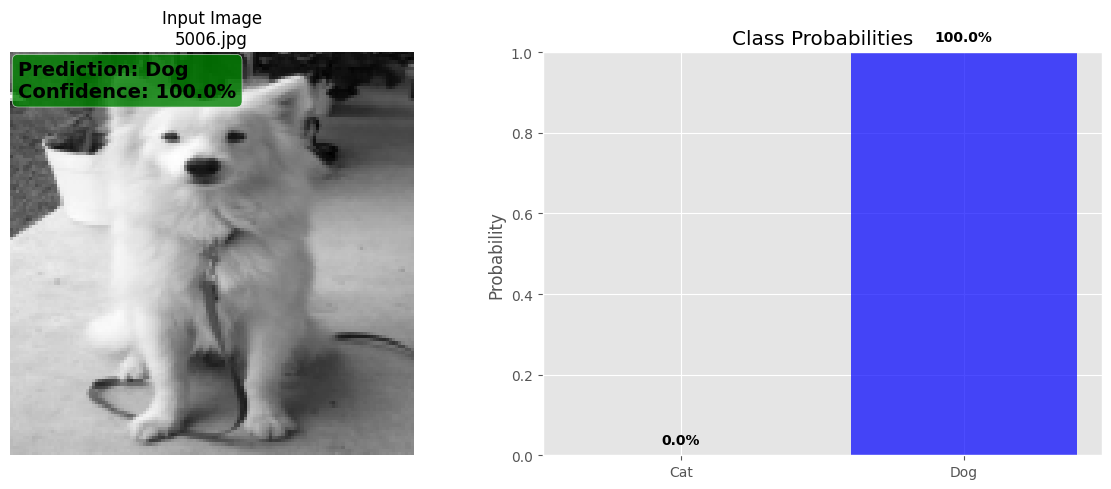

In [11]:
# SINGLE IMAGE PREDICTION AND VISUALIZATION

def predict_single_image(net, image_path, transform, device):
    """
    Predict if a single image is a cat or dog and show confidence
    """
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    # Store original for display
    original_img = img.copy()

    # ALWAYS apply the same preprocessing as training data
    if transform:
        # Use the provided transform
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    else:
        # Manual preprocessing to match training data
        img_resized = cv2.resize(img, (50, 50))  # Resize to 50x50 like training
        img_tensor = torch.from_numpy(img_resized).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        img_tensor = img_tensor / 255.0  # Normalize to [0,1]
        img_tensor = (img_tensor - 0.5) / 0.5  # Normalize to [-1,1] like training transform

    # Move to device
    img_tensor = img_tensor.to(device)

    # Make prediction
    net.eval()
    with torch.no_grad():
        outputs = net(img_tensor)
        feat = net.convs(img_tensor)
        print(feat.shape)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Interpret results
    class_names = ['Cat', 'Dog']
    prediction = class_names[predicted_class]

    return {
        'image': img_tensor.cpu()[0,0,:,:],
        'prediction': prediction,
        'confidence': confidence,
        'probabilities': {
            'Cat': probabilities[0][0].item(),
            'Dog': probabilities[0][1].item()
        }
    }

def visualize_prediction(result, image_path=""):
    """
    Create a nice visualization of the prediction
    """
    if result is None:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Show the image
    ax1.imshow(result['image'], cmap='gray')
    ax1.set_title(f'Input Image\n{image_path.split("/")[-1] if image_path else ""}', fontsize=12)
    ax1.axis('off')

    # Show prediction with confidence
    prediction = result['prediction']
    confidence = result['confidence']

    # Color based on confidence
    color = 'green' if confidence > 0.7 else 'orange' if confidence > 0.5 else 'red'

    ax1.text(0.02, 0.98, f'Prediction: {prediction}\nConfidence: {confidence:.1%}',
             transform=ax1.transAxes, fontsize=14, fontweight='bold',
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))

    # Show probability bar chart
    cats_prob = result['probabilities']['Cat']
    dogs_prob = result['probabilities']['Dog']

    bars = ax2.bar(['Cat', 'Dog'], [cats_prob, dogs_prob],
                   color=['orange', 'blue'], alpha=0.7)
    ax2.set_ylabel('Probability')
    ax2.set_title('Class Probabilities')
    ax2.set_ylim(0, 1)

    # Add percentage labels on bars
    for bar, prob in zip(bars, [cats_prob, dogs_prob]):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def test_random_from_dataset(net, dataset, transform, device, num_samples=5):
    """
    Test the model on random images from your dataset
    """
    import random

    print(f"Testing {num_samples} random images from dataset...")

    for i in range(num_samples):
        # Get random image from dataset
        random_idx = random.randint(0, len(dataset) - 1)
        img_tensor, true_label = dataset[random_idx]

        # Get the actual image path for display
        if dataset.labels[random_idx] == 0:  # Cat
            img_path = os.path.join(dataset.path_cat, dataset.images[random_idx])
        else:  # Dog
            img_path = os.path.join(dataset.path_dog, dataset.images[random_idx])

        # Make prediction using the same transform as training
        result = predict_single_image(net, img_path, transform, device)

        if result:
            true_class = 'Cat' if true_label == 0 else 'Dog'
            predicted_class = result['prediction']

            print(f"\nSample {i+1}:")
            print(f"True Label: {true_class}")
            print(f"Prediction: {predicted_class} ({result['confidence']:.1%} confidence)")
            print(f"Correct: {'✅' if true_class == predicted_class else '❌'}")

            # Visualize this prediction
            visualize_prediction(result, img_path)

def test_external_image(net, image_path, transform, device):
    """
    Test the model on any external image
    Usage: test_external_image(net, "/path/to/your/image.jpg", transform, device)
    """
    print(f"Testing external image: {image_path}")

    result = predict_single_image(net, image_path, transform, device)

    if result:
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.1%}")
        print(f"Cat probability: {result['probabilities']['Cat']:.1%}")
        print(f"Dog probability: {result['probabilities']['Dog']:.1%}")

        # Visualize the result
        visualize_prediction(result, image_path)

        return result
    else:
        print("Failed to process the image")
        return None

# ========================================
# RUN TESTS - UNCOMMENT THE ONES YOU WANT TO USE
# ========================================

print("\n" + "="*50)
print("TESTING THE TRAINED MODEL")
print("="*50)

# Test on random images from your dataset
test_random_from_dataset(net, dataset, transform, device, num_samples=3)

# Example of testing an external image (uncomment and modify path as needed):
# test_external_image(net, "/content/your_image.jpg", transform, device)


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


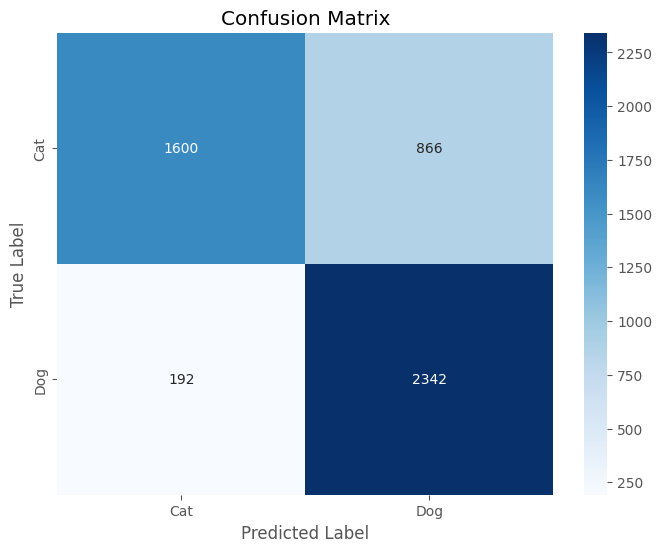


Confusion Matrix Analysis:
True Cats classified as Cats: 1600
True Cats classified as Dogs: 866 (False Positives)
True Dogs classified as Cats: 192 (False Negatives)
True Dogs classified as Dogs: 2342
Overall Accuracy: 0.788


In [14]:
# ========================================
# CONFUSION MATRIX
# ========================================
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, test_dataloader, device):
    net.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_dataloader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = net(batch_X)
            predicted = torch.argmax(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print metrics
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total

    print(f"\nConfusion Matrix Analysis:")
    print(f"True Cats classified as Cats: {cm[0,0]}")
    print(f"True Cats classified as Dogs: {cm[0,1]} (False Positives)")
    print(f"True Dogs classified as Cats: {cm[1,0]} (False Negatives)")
    print(f"True Dogs classified as Dogs: {cm[1,1]}")
    print(f"Overall Accuracy: {accuracy:.3f}")

# Generate confusion matrix
plot_confusion_matrix(net, val_dataloader, device)

Generating Grad-CAM visualizations...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


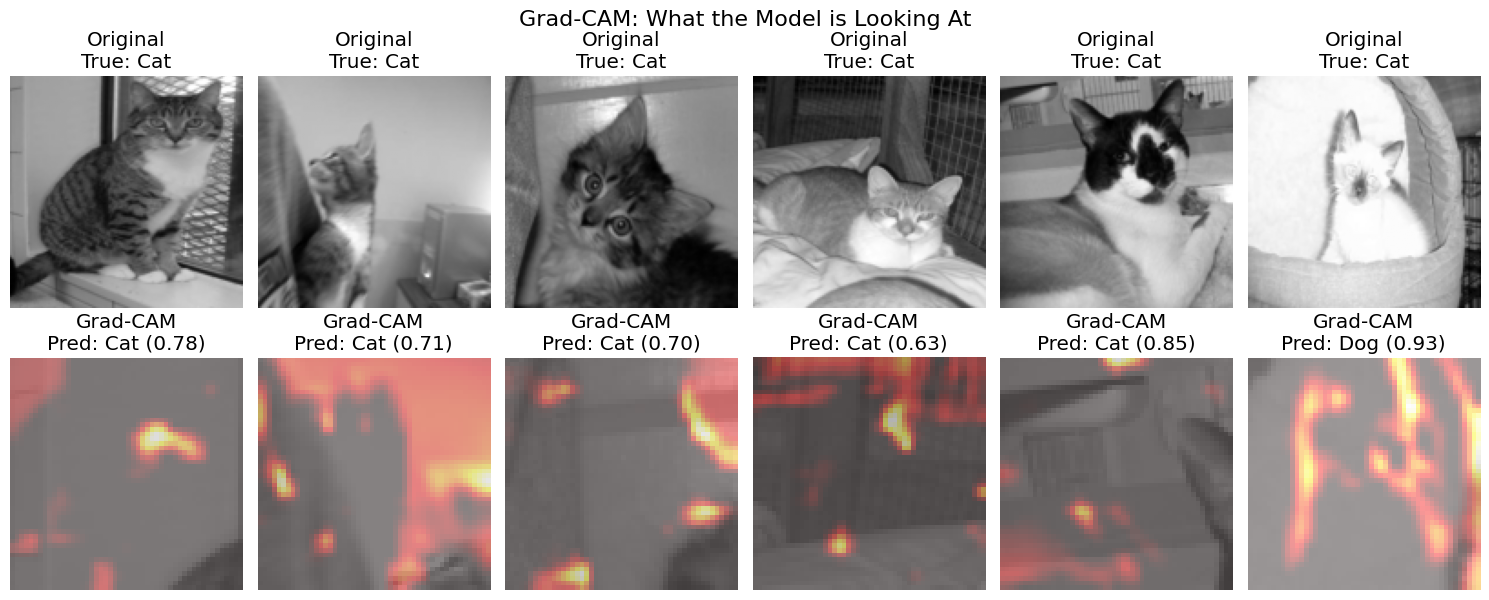


Generating Saliency Maps...


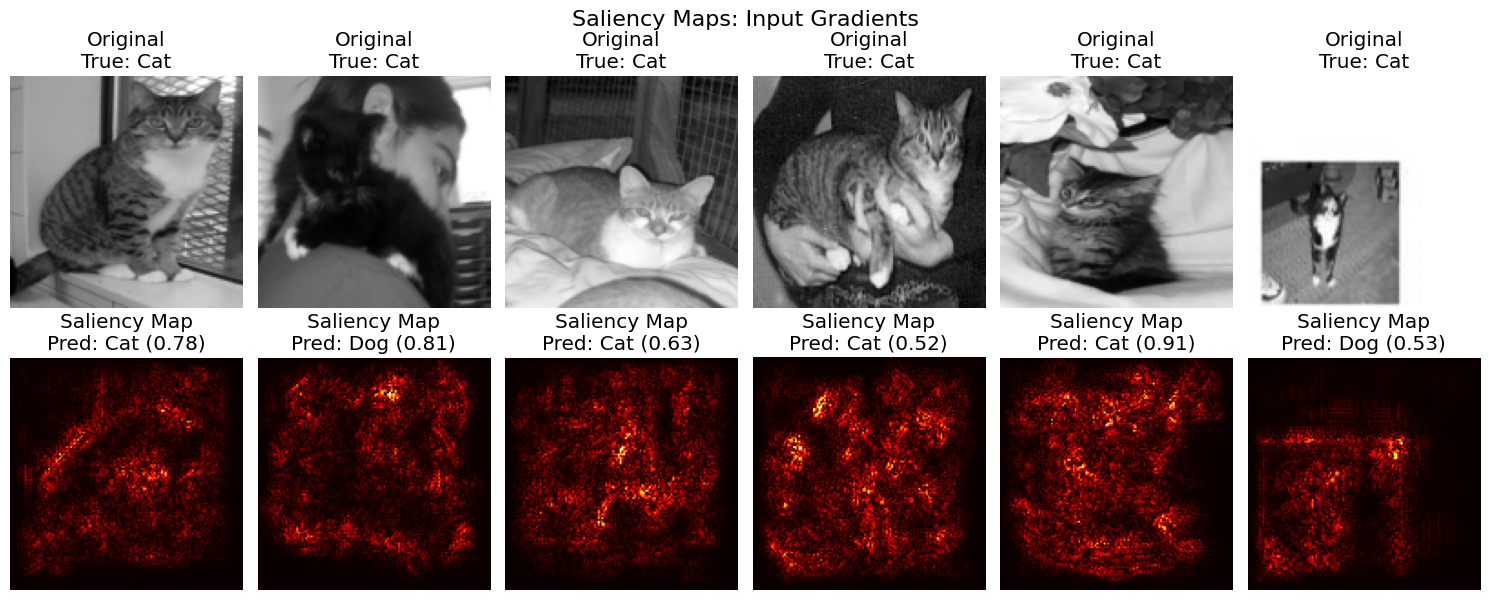

In [15]:
# ========================================
# GRAD-CAM VISUALIZATION
# ========================================
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to capture gradients and activations
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        # Backward pass
        self.model.zero_grad()
        output[0, target_class].backward()

        # Generate CAM
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam / torch.max(cam)

        return cam.cpu().numpy(), output

def visualize_gradcam(net, dataset, device, num_samples=6):
    # Create Grad-CAM for the last conv layer (conv3)
    gradcam = GradCAM(net, net.conv3)

    net.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Get a sample
        img, true_label = dataset[i * 100]  # Sample every 100th image
        img_batch = img.unsqueeze(0).to(device)

        # Generate Grad-CAM
        cam, output = gradcam.generate_cam(img_batch)
        pred_label = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1).max().item()

        # Original image
        original_img = img.squeeze().cpu().numpy()
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title(f'Original\nTrue: {"Cat" if true_label == 0 else "Dog"}')
        axes[0, i].axis('off')

        # Grad-CAM heatmap
        # Resize CAM to match original image size
        cam_resized = cv2.resize(cam, (50, 50))

        # Overlay heatmap on original image
        axes[1, i].imshow(original_img, cmap='gray', alpha=0.6)
        axes[1, i].imshow(cam_resized, cmap='hot', alpha=0.4)
        axes[1, i].set_title(f'Grad-CAM\nPred: {"Cat" if pred_label == 0 else "Dog"} ({confidence:.2f})')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.suptitle('Grad-CAM: What the Model is Looking At', fontsize=16, y=1.02)
    plt.show()

def visualize_saliency_maps(net, dataset, device, num_samples=6):
    """Simple saliency maps using input gradients"""
    net.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Get a sample
        img, true_label = dataset[i * 150]  # Different samples
        img_batch = img.unsqueeze(0).to(device)
        img_batch.requires_grad_()

        # Forward pass
        output = net(img_batch)
        pred_class = torch.argmax(output, dim=1)

        # Backward pass
        net.zero_grad()
        output[0, pred_class].backward()

        # Get gradients
        gradients = img_batch.grad.data.abs()
        saliency = gradients.squeeze().cpu().numpy()

        # Original image
        original_img = img.squeeze().cpu().numpy()
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title(f'Original\nTrue: {"Cat" if true_label == 0 else "Dog"}')
        axes[0, i].axis('off')

        # Saliency map
        axes[1, i].imshow(saliency, cmap='hot')
        pred_label = pred_class.item()
        confidence = F.softmax(output, dim=1).max().item()
        axes[1, i].set_title(f'Saliency Map\nPred: {"Cat" if pred_label == 0 else "Dog"} ({confidence:.2f})')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.suptitle('Saliency Maps: Input Gradients', fontsize=16, y=1.02)
    plt.show()

# Generate visualizations
print("Generating Grad-CAM visualizations...")
visualize_gradcam(net, dataset, device, num_samples=6)

print("\nGenerating Saliency Maps...")
visualize_saliency_maps(net, dataset, device, num_samples=6)